#Przegląd

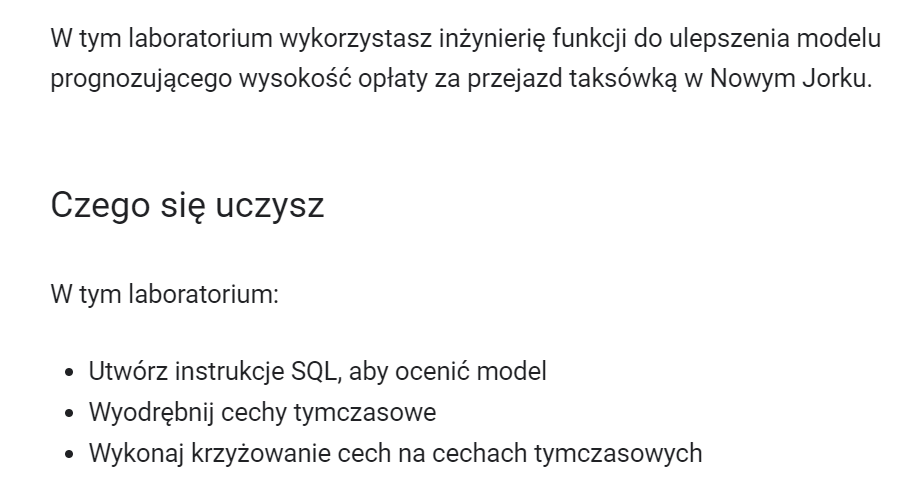

#Zadanie 1. Włącz wszystkie zalecane API

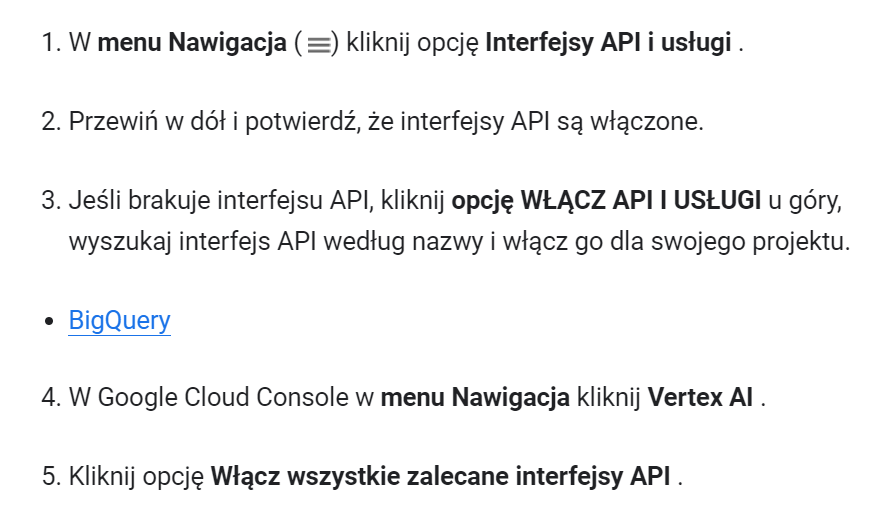

#Zadanie 2. Uruchom instancję Vertex AI Notebooks

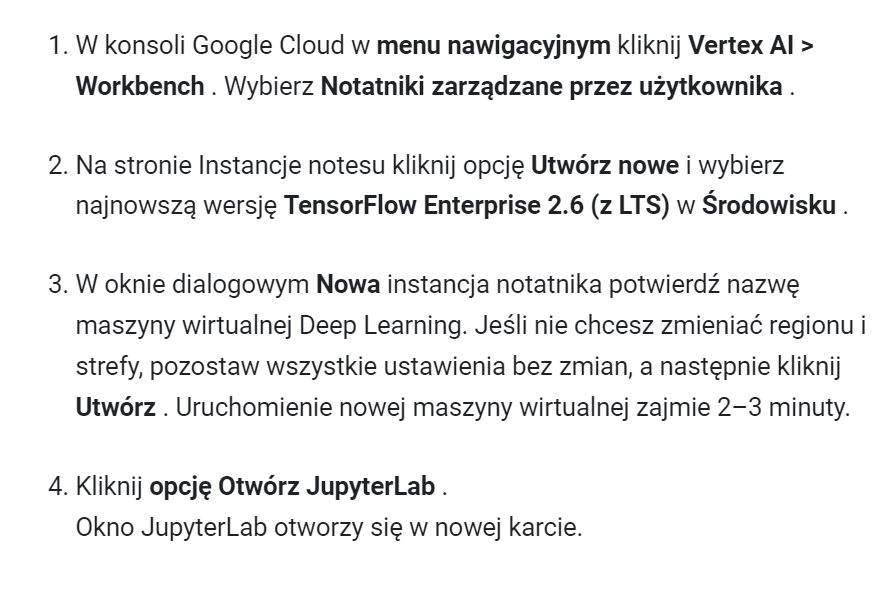

#Zadanie 3. Sklonuj repozytorium kursu w instancji Vertex AI Notebooks

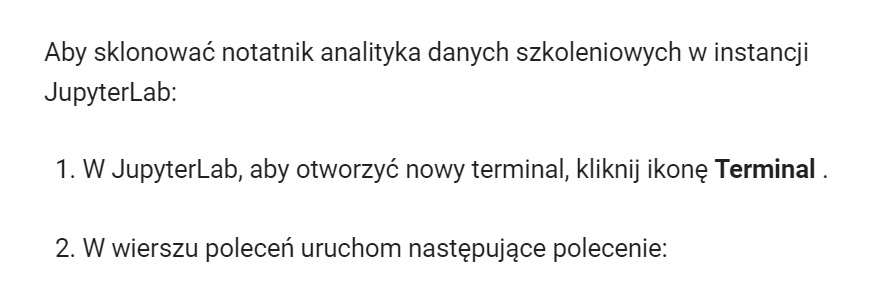

In [ ]:
git clone https://github.com/GoogleCloudPlatform/training-data-analyst

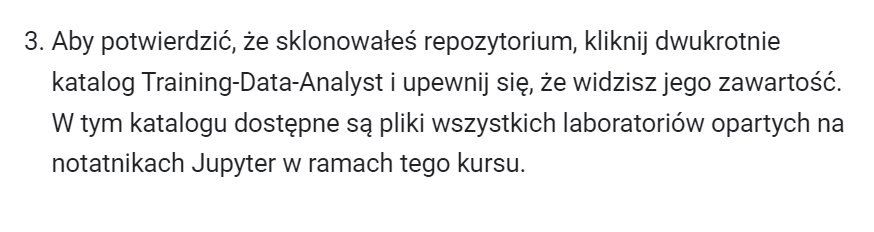

#Zadanie 4. Wykonanie podstawowej inżynierii cech w języku BQML

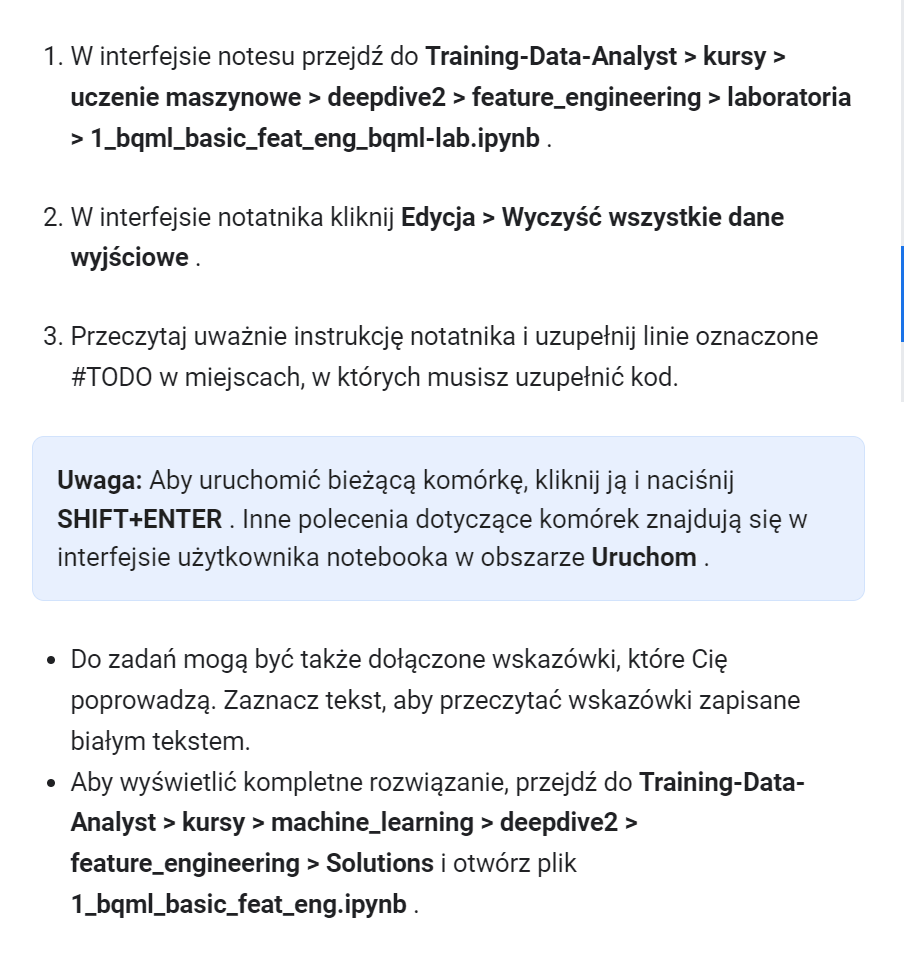

# Basic Feature Engineering in BQML

**Cele kształcenia**

1. Utwórz instrukcje SQL, aby ocenić model
2. Wyodrębnij cechy tymczasowe
3. Wykonaj krzyżowanie cech na cechach czasowych


## Wstęp
W tym laboratorium wykorzystujemy inżynierię funkcji, aby ulepszyć przewidywanie wysokości opłaty za przejazd taksówką w Nowym Jorku. Wykorzystamy BigQuery ML do zbudowania modelu przewidywania kosztów przejazdów, a inżynieria funkcji umożliwi ulepszenie i utworzenie ostatecznego modelu.

W tym Notatniku konfigurujemy środowisko, tworzymy zbiór danych projektu, tworzymy tabelę inżynierii cech, tworzymy i oceniamy model bazowy, wyodrębniamy cechy tymczasowe, przeprowadzamy krzyżowanie cech na cechach czasowych i oceniamy wydajność modelu w całym procesie.



### Skonfiguruj zmienne środowiskowe i załaduj niezbędne biblioteki

In [ ]:
# Installing the latest version of the package
!pip install --user google-cloud-bigquery==3.4.1

**Uwaga**: Uruchom ponownie jądro, aby użyć zaktualizowanych pakietów.

Prosimy zignorować ostrzeżenia o wycofaniu i błędy dotyczące niezgodności związane z Google-Cloud-Storage.

In [ ]:
# Instalacja najnowszej wersji pakietu
import tensorflow as tf
print("TensorFlow version: ",tf.version.VERSION)

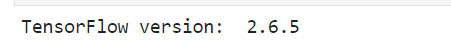

In [ ]:
%%bash
# Exporting the project

export PROJECT=$(gcloud config list project --format "value(core.project)")
echo "Your current GCP Project Name is: "$PROJECT

Your current GCP Project Name is: munn-sandbox


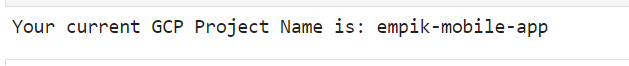

## Źródłowy zbiór danych

Nasz zbiór danych jest przechowywany w [BigQuery](https://cloud.google.com/bigquery/). Dane dotyczące opłat za taksówkę to publicznie dostępny zbiór danych, co oznacza, że każdy, kto ma konto GCP, ma do nich dostęp. Kliknij [tutaj](https://console.cloud.google.com/bigquery?project=bigquery-public-data&p=nyc-tlc&d=yellow&t=trips&page=table), aby uzyskać dostęp do zbioru danych.

Zbiór danych dotyczących opłat za taksówkę jest stosunkowo duży i zawiera 55 milionów wierszy szkoleniowych, ale jest łatwy do zrozumienia i zawiera tylko sześć funkcji. Fare_amount to wartość docelowa, ciągła wartość, którą będziemy szkolić, aby przewidywać model.

## Utwórz zbiór danych BigQuery

Zbiór danych BigQuery to kontener na tabele, widoki i modele utworzone za pomocą BigQuery ML. Stwórzmy taki o nazwie __feat_eng__, jeśli nie zrobiliśmy tego jeszcze we wcześniejszym laboratorium. Zrobimy to samo dla wiadra GCS dla naszego projektu.

In [ ]:
%%bash

# Create a BigQuery dataset for feat_eng if it doesn't exist
datasetexists=$(bq ls -d | grep -w feat_eng)

if [ -n "$datasetexists" ]; then
    echo -e "BigQuery dataset already exists, let's not recreate it."

else
    echo "Creating BigQuery dataset titled: feat_eng"

    bq --location=US mk --dataset \
        --description 'Taxi Fare' \
        $PROJECT:feat_eng
   echo "\nHere are your current datasets:"
   bq ls
fi

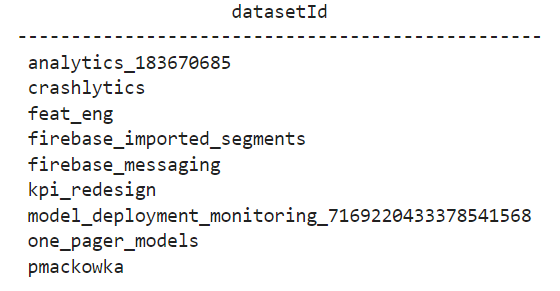

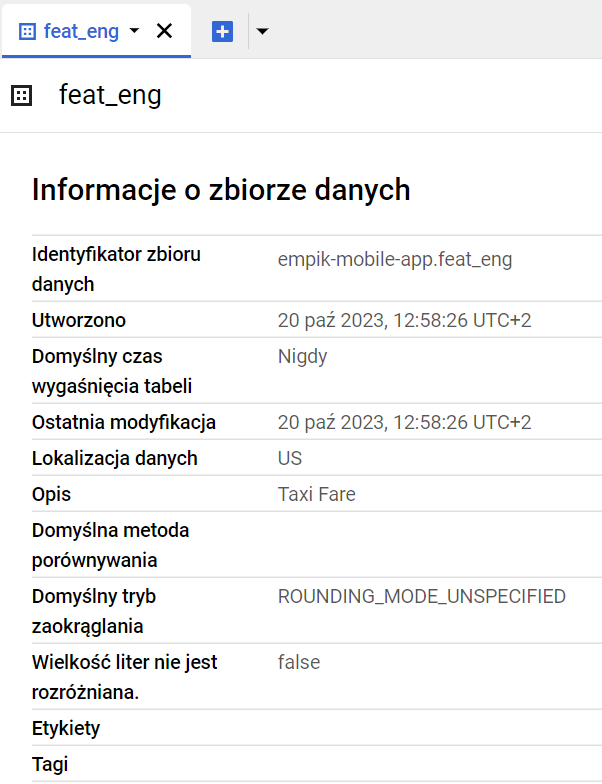

## Utwórz tabelę danych szkoleniowych

Ponieważ istnieje już publicznie dostępny zbiór danych, możemy po prostu utworzyć tabelę danych szkoleniowych, korzystając z tych surowych danych wejściowych. Zwróć uwagę na klauzulę WHERE w poniższym zapytaniu: Klauzula ta pozwala nam przeszkolić część danych (np. sto tysięcy wierszy w porównaniu z milionem wierszy), co pozwala obniżyć koszty zapytania. Jeśli potrzebujesz odświeżenia wiedzy na temat używania MOD() do powtarzalnych podziałów, zobacz ten [post](https://www.oreilly.com/learning/repeatable-sampling-of-data-sets-in-bigquery-for-machine-learning ).

**Uwaga:** Zbiór danych w kodzie tworzenia tabeli poniżej jest tym, który został utworzony wcześniej, np. "feat_eng". Nazwa tabeli to „feateng_training_data”. **Uruchom zapytanie, aby utworzyć tabelę**.

In [ ]:
%%bigquery

CREATE OR REPLACE TABLE
  feat_eng.feateng_training_data AS
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  passenger_count*1.0 AS passengers,
  pickup_datetime,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat
FROM
  `nyc-tlc.yellow.trips`
WHERE
  MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), 10000) = 1
  AND fare_amount >= 2.5
  AND passenger_count > 0
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45

""


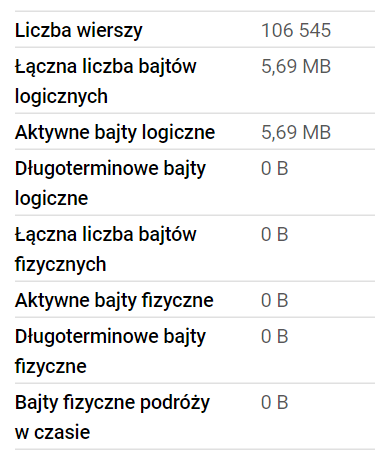

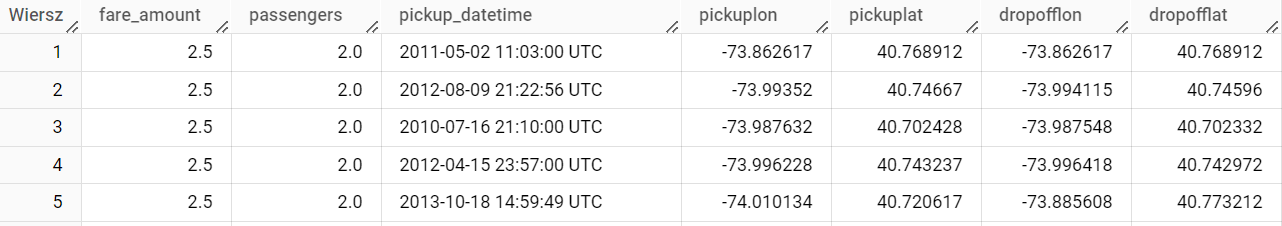

In [ ]:
%%bigquery

SELECT * FROM `empik-mobile-app.feat_eng.feateng_training_data` LIMIT 1000

## Sprawdź utworzenie tabeli

Sprawdź, czy utworzono zestaw danych.


In [ ]:
%%bigquery

# LIMIT 0 to zapytanie bezpłatne; pozwala nam to sprawdzić, czy tabela istnieje.
SELECT
*
FROM
  feat_eng.feateng_training_data
LIMIT
  0

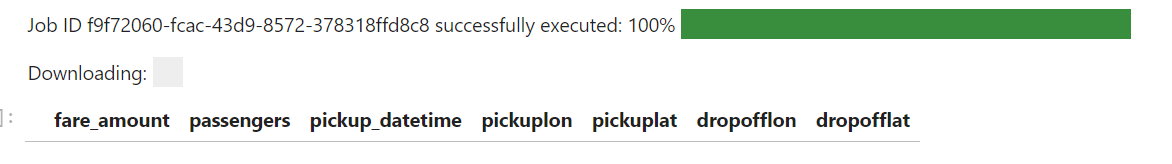

### Model bazowy: utwórz model bazowy

Następnie tworzysz model bazowy regresji liniowej bez inżynierii cech. Przypomnijmy, że model w BigQuery ML reprezentuje to, czego system ML nauczył się z danych szkoleniowych. Model bazowy to rozwiązanie problemu bez stosowania technik uczenia maszynowego.

Tworząc model BQML należy określić typ modelu (w naszym przypadku regresja liniowa) oraz etykietę wejściową (fare_amount). Należy również zauważyć, że jako źródła danych używamy tabeli danych szkoleniowych.

Teraz tworzymy instrukcję SQL, aby utworzyć model bazowy.

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL
  feat_eng.baseline_model OPTIONS (model_type='linear_reg',
    input_label_cols=['fare_amount']) AS
SELECT
  fare_amount,
  passengers,
  pickup_datetime,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat
FROM
  feat_eng.feateng_training_data

""


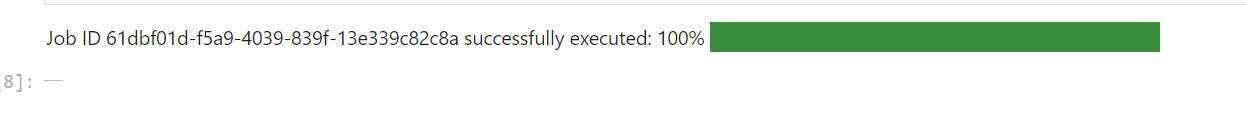

Uwaga: wykonanie zapytania może zająć kilka minut. Po zakończeniu pierwszej iteracji Twój model (model_bazowy) pojawi się w panelu nawigacyjnym internetowego interfejsu użytkownika BigQuery. Ponieważ zapytanie używa instrukcji `CREATE MODEL` do utworzenia modelu, wyniki zapytania nie są widoczne.

Możesz obserwować trenowanie modelu, przeglądając kartę Statystyki modelu w internetowym interfejsie użytkownika BigQuery. Po zakończeniu pierwszej iteracji zakładka jest aktualizowana. Statystyki są nadal aktualizowane po zakończeniu każdej iteracji.

Po zakończeniu szkolenia odwiedź [BigQuery Cloud Console](https://console.cloud.google.com/bigquery) i przyjrzyj się wytrenowanemu modelowi. Następnie wróć do tego notatnika.

### Oceń model bazowy
Pamiętaj, że BigQuery automatycznie dzieli przekazane przez nas dane, szkoli tylko część danych, a resztę wykorzystuje do oceny. Po utworzeniu modelu oceniasz wydajność regresora za pomocą funkcji `ML.EVALUATE`. Funkcja `ML.EVALUATE` porównuje przewidywane wartości z rzeczywistymi danymi.

UWAGA: wyniki są również wyświetlane w [konsoli BigQuery Cloud Console](https://console.cloud.google.com/bigquery) na karcie **Ocena**.

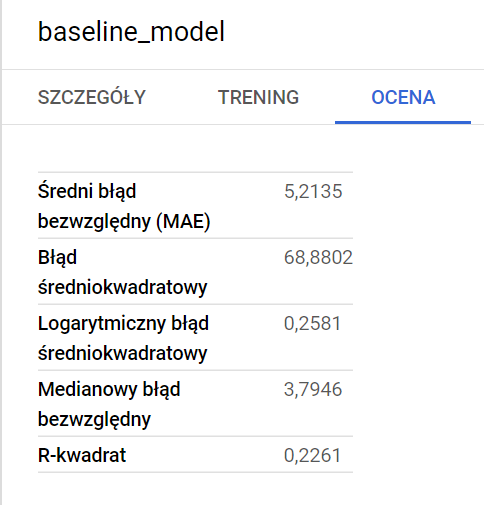

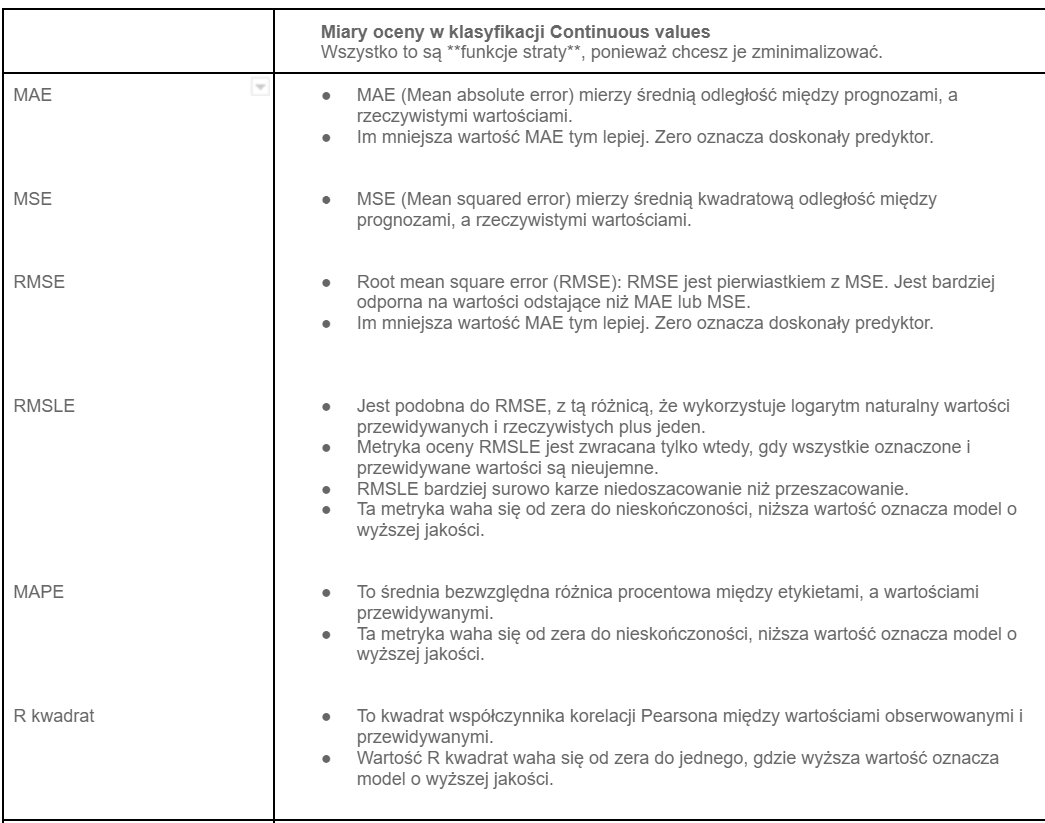

Przejrzyj statystyki uczenia się i ewaluacji dla modelu baseline_model.

In [ ]:
%%bigquery

# Statystyki ewaluacyjne dotyczące przechowywanych danych.
# W tym przypadku funkcja ML.EVALUATE jest używana do oceny metryk modelu
SELECT
  *,
  SQRT(loss) AS rmse
FROM
  ML.TRAINING_INFO(MODEL feat_eng.baseline_model)

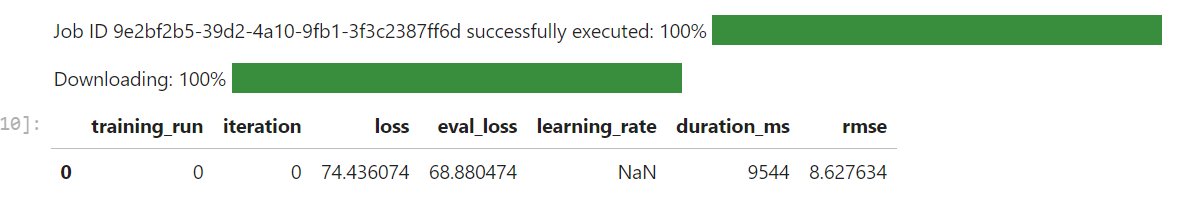

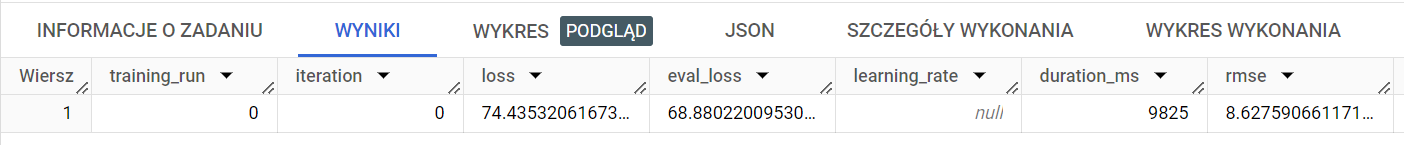

In [ ]:
%%bigquery

# W tym przypadku funkcja ML.EVALUATE jest używana do oceny metryk modelu
SELECT
  *
FROM
  ML.EVALUATE(MODEL feat_eng.baseline_model)

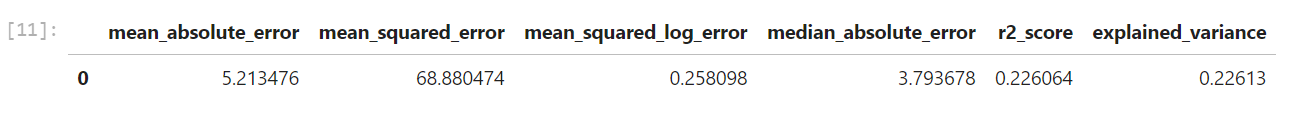

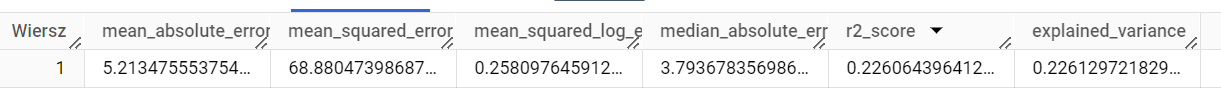

**UWAGA:** Ponieważ przeprowadzono regresję liniową, wyniki obejmują następujące kolumny:

*   mean_absolute_error
*   mean_squared_error
*   mean_squared_log_error
*   median_absolute_error
*   r2_score
*   explained_variance

**Źródło** zawierające wyjaśnienie [wskaźników regresji](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234).

**Mean squared error** (MSE) - mierzy różnicę pomiędzy wartościami przewidywanymi przez nasz model na podstawie zbioru testowego a wartościami rzeczywistymi. Można to również traktować jako odległość między linią regresji (najlepszego dopasowania) a przewidywanymi wartościami.

**Root mean squared error** (RMSE) - Podstawową metryką oceny tego problemu ML jest RMSE. RMSE mierzy różnicę między przewidywaniami modelu a obserwowanymi wartościami. Duży RMSE jest równoważny large average error, więc mniejsze wartości RMSE są lepsze. Jedną z ciekawych właściwości RMSE jest to, że błąd jest podawany w mierzonych jednostkach, dzięki czemu można bardzo bezpośrednio stwierdzić, jak nieprawidłowy może być model na podstawie niewidocznych danych.

**R2**: Ważnym miernikiem wyników oceny jest wynik R2. Wynik R2 to miara statystyczna określająca, czy przewidywania regresji liniowej są przybliżone do rzeczywistych danych. Zero (0) wskazuje, że model nie wyjaśnia żadnej zmienności danych odpowiedzi wokół średniej. Jeden (1) wskazuje, że model wyjaśnia całą zmienność danych odpowiedzi wokół średniej.

Następnie piszemy zapytanie SQL, aby przyjąć funkcję `SQRT()` błędu średniokwadratowego jako metrykę strat do oceny dla modelu porównawczego.

In [ ]:
%%bigquery
#TODO 1

# W tym przypadku funkcja ML.EVALUATE jest używana do oceny metryk modelu
SELECT
  SQRT(mean_squared_error) AS rmse
FROM
  ML.EVALUATE(MODEL feat_eng.baseline_model)

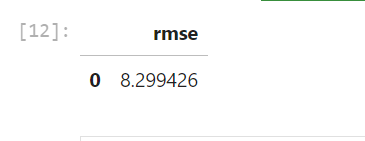

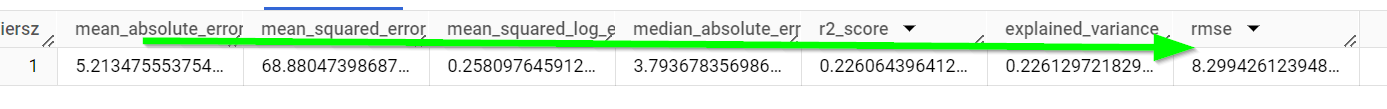

#### Model 1:  EXTRACT dayofweek from the pickup_datetime feature.

* Jak pamiętasz, dzień tygodnia jest wyliczeniem reprezentującym 7 dni tygodnia. Ta fabryka umożliwia uzyskanie wyliczenia z wartości int. Wartość int jest zgodna ze standardem ISO-8601, od 1 (poniedziałek) do 7 (niedziela).

* Jeśli chcesz wyodrębnić dzień tygodnia z daty_odbioru przy użyciu BigQuery SQL, zwrócony typ danych będzie liczbą całkowitą.

Następnie tworzymy model o nazwie „model_1” na podstawie modelu porównawczego i wyodrębniamy dzień tygodnia.

In [ ]:
%%bigquery
#TODO 2

CREATE OR REPLACE MODEL
  feat_eng.model_1 OPTIONS (model_type='linear_reg',
  input_label_cols=['fare_amount']) AS
SELECT
  fare_amount,
  passengers,
  pickup_datetime,
  EXTRACT(DAYOFWEEK FROM pickup_datetime) AS dayofweek,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat
FROM
  feat_eng.feateng_training_data

""


Po zakończeniu szkolenia odwiedź [BigQuery Cloud Console](https://console.cloud.google.com/bigquery) i przyjrzyj się wytrenowanemu modelowi. Następnie wróć do tego notatnika.

Następnie dwie różne instrukcje SQL pokazują metryki `TRAINING` i `EVALUATION` modelu_1.

In [ ]:
%%bigquery

# Tutaj funkcja ML.TRAINING_INFO służy do wyświetlania informacji o iteracjach uczących modelu.
SELECT
  *,
  SQRT(loss) AS rmse
FROM
  ML.TRAINING_INFO(MODEL feat_eng.model_1)

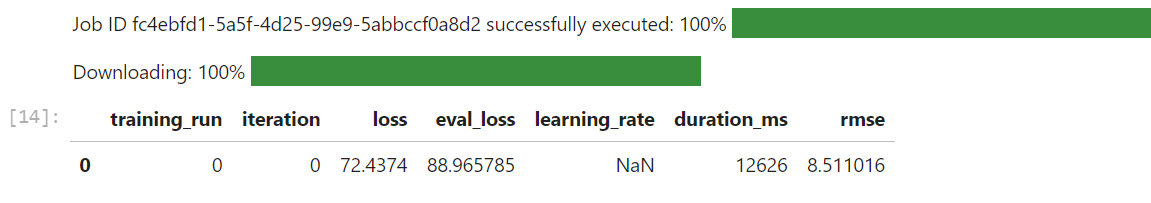

In [ ]:
%%bigquery

# W tym przypadku funkcja ML.EVALUATE jest używana do oceny metryk modelu
SELECT
  *
FROM
  ML.EVALUATE(MODEL feat_eng.model_1)

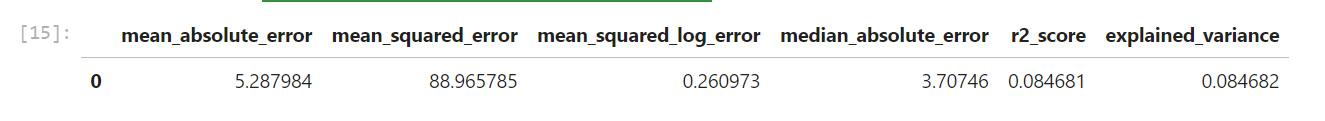

Tutaj uruchamiamy zapytanie SQL, aby przyjąć funkcję `SQRT()` błędu średniokwadratowego jako metrykę strat do oceny dla modelu porównawczego.

In [ ]:
%%bigquery

# Here, ML.EVALUATE function is used to evaluate model metrics
SELECT
  SQRT(mean_squared_error) AS rmse
FROM
  ML.EVALUATE(MODEL feat_eng.model_1)

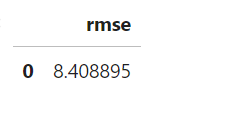

### Model 2:  EXTRACT hourofday from the pickup_datetime feature

Jak pamiętasz,

**pickup_datetime** jest przechowywany jako TIMESTAMP, gdzie format Timestamp jest pobierany w standardowym formacie wyjściowym – rok-miesiąc-dzień godzina:minuta:sekunda (np. 2016-01-01 23:59:59).

**Hourofday** zwraca liczbę całkowitą reprezentującą numer godziny danej daty.

Godzinę dnia najlepiej traktować jako dyskretną zmienną porządkową (a nie cechę kategoryczną), ponieważ można uszeregować godziny (np. istnieje naturalny porządek wartości). Godzina dnia ma dodatkową cechę cykliczności, ponieważ godzina 12:00 następuje po 23:00 i poprzedza 1:00.

Następnie tworzymy model o nazwie „model_2” i WYCIĄGAMY godzinę dnia z funkcji pickup_datetime, aby poprawić skuteczność naszego modelu (RMSE).

In [ ]:
%%bigquery
#TODO 3a

CREATE OR REPLACE MODEL
  feat_eng.model_2 OPTIONS (model_type='linear_reg',
    input_label_cols=['fare_amount']) AS
SELECT
  fare_amount,
  passengers,
  #pickup_datetime,
  EXTRACT(DAYOFWEEK FROM pickup_datetime) AS dayofweek,
  EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat
FROM
  `feat_eng.feateng_training_data`

""


In [ ]:
%%bigquery

# Here, ML.EVALUATE function is used to evaluate model metrics
SELECT
  *
FROM
  ML.EVALUATE(MODEL feat_eng.model_2)

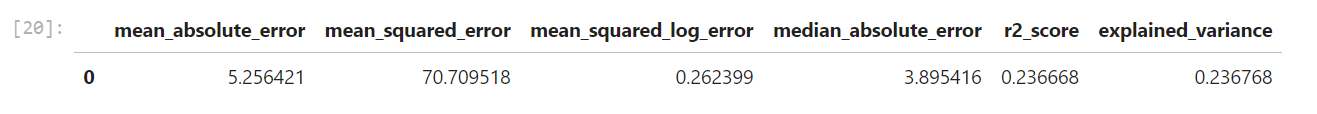

In [ ]:
%%bigquery

# W tym przypadku funkcja ML.EVALUATE jest używana do oceny metryk modelu
SELECT
  SQRT(mean_squared_error) AS rmse
FROM
  ML.EVALUATE(MODEL feat_eng.model_2)

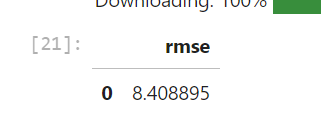

### Model 3: Funkcja krzyżowania dni tygodnia i godzin przy użyciu CONCAT

Najpierw pozwólmy modelowi uczyć się wzorców ruchu, tworząc nową funkcję, która łączy porę dnia i dzień tygodnia (nazywa się to [feature cross](https://developers.google.com/machine-learning/crash-course/feature-crosses/video-lecture).

Uwaga: BQML domyślnie zakłada, że liczby są cechami numerycznymi, a ciągi znaków są cechami kategorycznymi. Musimy przekonwertować zarówno funkcje dnia tygodnia, jak i godziny na string, ponieważ model (sieć neuronowa) automatycznie traktuje każdą liczbę całkowitą jako wartość liczbową, a nie wartość kategorialną. Zatem, jeśli nie zostanie rzutowany jako string, funkcja dnia tygodnia będzie interpretowana jako wartości liczbowe (np. 1,2,3,4,5,6,7), a godzina dnia będzie również interpretowana jako wartości liczbowe (np. dzień zaczyna się o północy , 00:00, a ostatnia minuta dnia rozpoczyna się o godzinie 23:59 i kończy o godzinie 24:00). W związku z tym nie ma możliwości „numerycznego” rozróżnienia „krzyżowania funkcji” godziny dnia i dnia tygodnia. Rzutowanie dnia tygodnia i godziny na ciągi znaków zapewnia, że każdy element będzie traktowany jak etykieta i będzie miał powiązany z nim własny współczynnik.

Utwórz instrukcję SQL, aby uwzględnić dzień tygodnia i godzinę za pomocą funkcji CONCAT. Nazwij model „model_3”

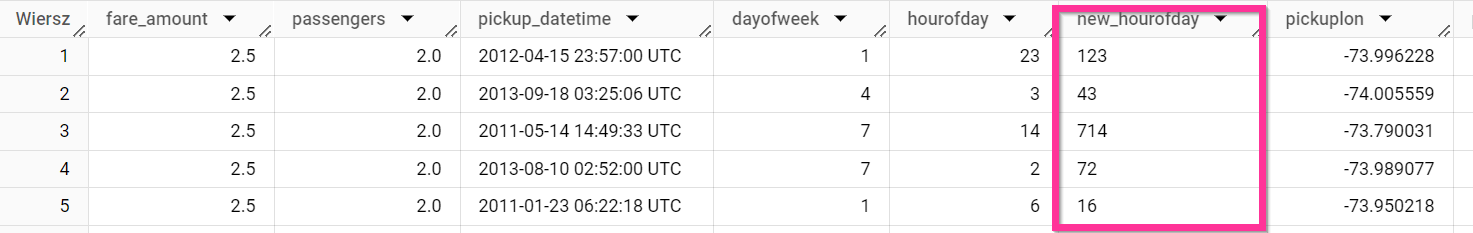

In [ ]:
%%bigquery
#TODO 3a

CREATE OR REPLACE MODEL
  feat_eng.model_3 OPTIONS (model_type='linear_reg',
    input_label_cols=['fare_amount']) AS
SELECT
  fare_amount,
  passengers,
  #pickup_datetime,
  #EXTRACT(DAYOFWEEK FROM pickup_datetime) AS dayofweek,
  #EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  CONCAT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING), CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING)) AS hourofday,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat
FROM
  `feat_eng.feateng_training_data`

""


In [ ]:
%%bigquery

# Here, ML.EVALUATE function is used to evaluate model metrics
SELECT
  *
FROM
  ML.EVALUATE(MODEL feat_eng.model_3)

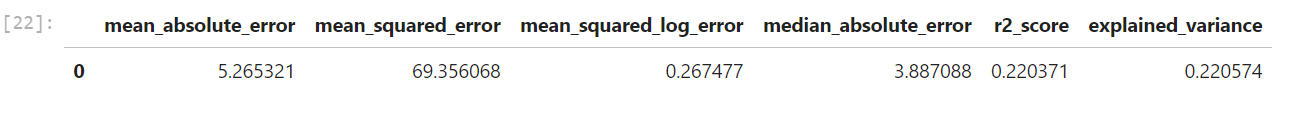

In [ ]:
%%bigquery

# W tym przypadku funkcja ML.EVALUATE jest używana do oceny metryk modelu
SELECT
  SQRT(mean_squared_error) AS rmse
FROM
  ML.EVALUATE(MODEL feat_eng.model_3)

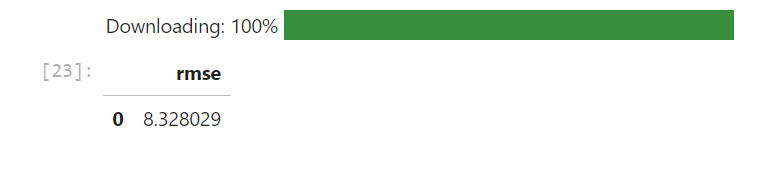

Opcjonalnie: Utwórz tabelę podsumowującą RMSE, aby ocenić wydajność modelu.

| Model          | Taxi Fare | Description                                  |
|----------------|-----------|----------------------------------------------|
| baseline_model | 8.62      | Baseline model - no feature engineering    |
| model_1        | 9.43      | EXTRACT dayofweek from the pickup_datetime |
| model_2        | 8.40      | EXTRACT hourofday from the pickup_datetime |
| model_3        | 8.32      | FEATURE CROSS hourofday and dayofweek      |

Copyright 2021 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.